## **Importing Important libraries**

In [ ]:
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imutils

import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,ImageDataGenerator, array_to_img
from tensorflow.keras.applications import EfficientNetB1, MobileNetV2

from tensorflow.keras.models import Model,load_model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau


## Dataset Loading

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset


 98% 146M/149M [00:05<00:00, 43.7MB/s]
100% 149M/149M [00:05<00:00, 28.2MB/s]


In [ ]:
!unzip brain-tumor-mri-dataset.zip


Streaming output truncated to the last 5000 lines.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/

In [ ]:
#create directory for training data
os.mkdir('/content/Crop-Brain-MRI')
os.mkdir('/content/Crop-Brain-MRI/glioma_tumor')
os.mkdir('/content/Crop-Brain-MRI/meningioma_tumor')
os.mkdir('/content/Crop-Brain-MRI/pituitary_tumor')
os.mkdir('/content/Crop-Brain-MRI/no_tumor')


#create directory for testing data
os.mkdir('/content/Test-Data')
os.mkdir('/content/Test-Data/glioma_tumor')
os.mkdir('/content/Test-Data/meningioma_tumor')
os.mkdir('/content/Test-Data/pituitary_tumor')
os.mkdir('/content/Test-Data/no_tumor')

In [ ]:
train_dir = '/content/Training/'
test_dir = '/content/Testing/'

In [ ]:
classes = os.listdir('/content/Training')

In [ ]:
classes

['meningioma', 'pituitary', 'notumor', 'glioma']

In [ ]:
files_path_dict = {}

for c in classes:
  files_path_dict[c] = list(map(lambda x: train_dir + c + '/' + x, os.listdir(train_dir + c)))

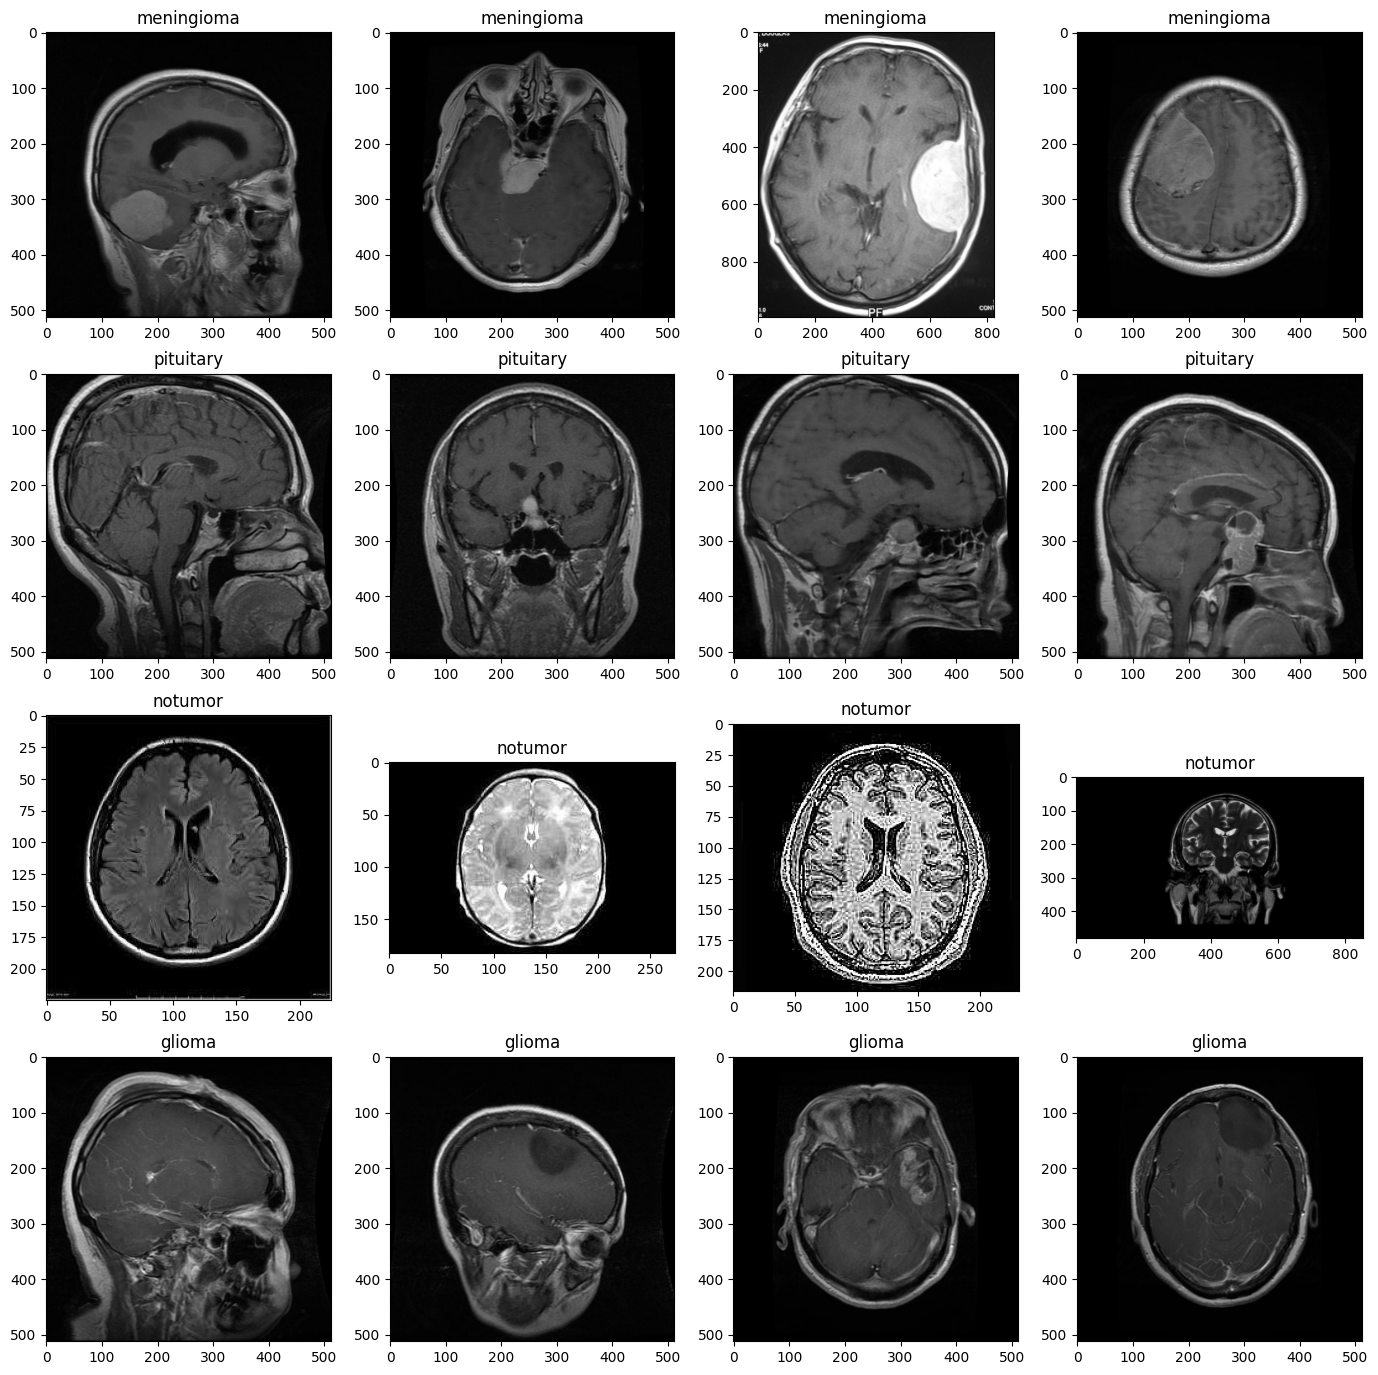

In [ ]:
#visualize
plt.figure(figsize = (17,17))
index = 0
for c in classes:
  random.shuffle(files_path_dict[c])
  path_list = files_path_dict[c][:5]

  for i in range(1, 5):
    index += 1
    plt.subplot(4, 4, index)
    plt.imshow(load_img(path_list[i]))
    plt.title(c)

# **Number of Images**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
No_images_per_class = []
Class_name = []

for i in os.listdir('/content/Training'):
  train_class = os.listdir(os.path.join('/content/Training', i))
  No_images_per_class.append(len(train_class))
  Class_name.append(i)
  print('Number of images in {} = {} \n'.format(i, len(train_class)))

Number of images in meningioma = 1339 

Number of images in pituitary = 1457 

Number of images in notumor = 1595 

Number of images in glioma = 1321 



In [ ]:
No_images_per_class = []
Class_name = []

for i in os.listdir('/content/Testing'):
  train_class = os.listdir(os.path.join('/content/Testing', i))
  No_images_per_class.append(len(train_class))
  Class_name.append(i)
  print('Number of images in {} = {} \n'.format(i, len(train_class)))

Number of images in meningioma = 306 

Number of images in pituitary = 300 

Number of images in notumor = 405 

Number of images in glioma = 300 



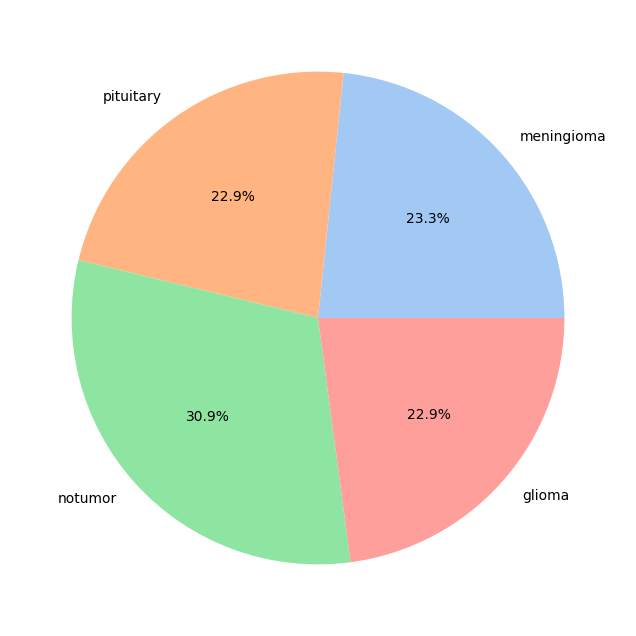

In [ ]:

#visualize class distribution in train set
import seaborn as sns
plt.figure(figsize=(8, 8))
colors = sns.color_palette('pastel')
plt.pie(No_images_per_class,
        labels = Class_name,
        autopct = '%1.1f%%',
        colors=colors)
plt.show()

In [ ]:
from sklearn.utils import shuffle
train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(train_dir+label):
        train_paths.append(train_dir+label+'/'+image)
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)


test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(test_dir+label):
        test_paths.append(test_dir+label+'/'+image)
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

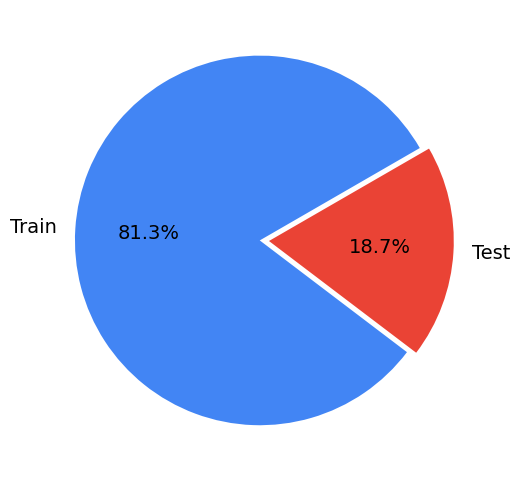

In [ ]:
plt.figure(figsize=(14,6))
colors = ['#4285f4', '#ea4335', '#fbbc05', '#34a853']
plt.rcParams.update({'font.size': 14})
plt.pie([len(train_labels), len(test_labels)],
        labels=['Train','Test'],
        colors=colors, autopct='%.1f%%', explode=(0.05,0),
        startangle=30);

## morphological Operations on Images

In [ ]:
def crop_image(image, plot=False):

    #convert to grayscale
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    #blur
    img_gray = cv2.GaussianBlur(img_gray, (5, 5), 0)

    #apply binary threshhold
    img_thresh = cv2.threshold(img_gray, 45, 255, cv2.THRESH_BINARY)[1]

    #apply erosion
    img_thresh = cv2.erode(img_thresh, None, iterations=2)

    #dilate images
    img_thresh = cv2.dilate(img_thresh, None, iterations=2)

    #find shapes or the contour of images
    contours = cv2.findContours(img_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    #grab contours
    contours = imutils.grab_contours(contours)

    #find biggest contour
    c = max(contours, key=cv2.contourArea)

    #extract contour positions
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    #generate new image
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    #plot
    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()

    return new_image

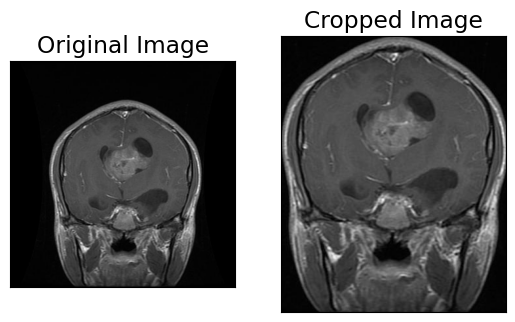

In [ ]:
example_image = cv2.imread('/content/Training/glioma/Tr-glTr_0001.jpg')
cropped_image = crop_image(example_image, plot=True)

crop training images and save it to the directory we previously created

In [ ]:
glioma = train_dir + 'glioma'
meningioma = train_dir + 'meningioma'
pituitary = train_dir + 'pituitary'
no_tumor = train_dir + 'notumor'

j = 0
for i in tqdm(os.listdir(glioma)):
  path = os.path.join(glioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = '/content/Crop-Brain-MRI/glioma_tumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1

j = 0
for i in tqdm(os.listdir(meningioma)):
  path = os.path.join(meningioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = '/content/Crop-Brain-MRI/meningioma_tumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1

j = 0
for i in tqdm(os.listdir(pituitary)):
  path = os.path.join(pituitary, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = '/content/Crop-Brain-MRI/pituitary_tumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1

j = 0
for i in tqdm(os.listdir(no_tumor)):
  path = os.path.join(no_tumor, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = '/content/Crop-Brain-MRI/no_tumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1

100%|██████████| 1595/1595 [00:08<00:00, 191.81it/s]


### **crop testing images and save it to the directory we previously created**

In [ ]:
test_glioma = test_dir + 'glioma'
test_meningioma = test_dir + 'meningioma'
test_pituitary = test_dir + 'pituitary'
test_no_tumor = test_dir + 'notumor'

j = 0
for i in tqdm(os.listdir(test_glioma)):
  path = os.path.join(test_glioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = '/content/Test-Data/glioma_tumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1

j = 0
for i in tqdm(os.listdir(test_meningioma)):
  path = os.path.join(test_meningioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = '/content/Test-Data/meningioma_tumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1

j = 0
for i in tqdm(os.listdir(test_pituitary)):
  path = os.path.join(test_pituitary, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = '/content/Test-Data/pituitary_tumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1

j = 0
for i in tqdm(os.listdir(test_no_tumor)):
  path = os.path.join(test_no_tumor, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)

  if img is not None:
    img = cv2.resize(img, (240, 240))
    save_path = '/content/Test-Data/no_tumor/' + str(j) + '.jpg'
    cv2.imwrite(save_path, img)
    j = j + 1

100%|██████████| 405/405 [00:01<00:00, 272.79it/s]


# **Data Augumentation**

In [ ]:
#use Image Data Generator to perform this task
#train set
datagen = ImageDataGenerator(rotation_range= 15,
                            width_shift_range=0.2,
                            height_shift_range=0.1,
                            horizontal_flip=True,
                            brightness_range = (0.7,1.3),
                            zoom_range = 0.1,
                            shear_range=0.1,
                            validation_split=0.2)

train_data = datagen.flow_from_directory('/content/Crop-Brain-MRI/',
                                         target_size=(240, 240),
                                         batch_size=32,
                                         class_mode='categorical',
                                         subset='training')

valid_data = datagen.flow_from_directory('/content/Crop-Brain-MRI/',
                                         target_size=(240, 240),
                                         batch_size=32,
                                         class_mode='categorical',
                                         subset='validation')

#test set
test_datagen = ImageDataGenerator()

test_data = datagen.flow_from_directory('/content/Test-Data/',
                                         target_size=(240, 240),
                                        class_mode='categorical',
                                        shuffle=False)

Found 4571 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [ ]:
#view the class dictionary
print(train_data.class_indices)
print(test_data.class_indices)

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


# **Augumented Data**

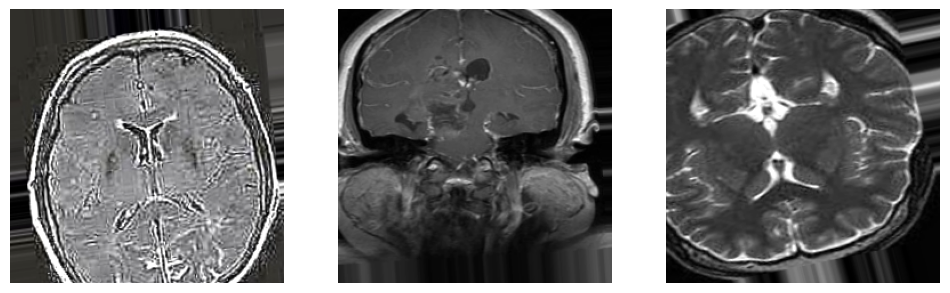

In [ ]:
#view the augmented data
sample_x, sample_y = next(train_data)
plt.figure(figsize=(12, 9))
for i in range(3):
  plt.subplot(1, 3, i+1)
  sample = array_to_img(sample_x[i])
  plt.axis('off')
  plt.grid(False)
  plt.imshow(sample)
plt.show()

# **Convolutional Neural Network Model (CNN) and Transfer Learning with MobileNet Versions**

# **MobileNetV2**

In [ ]:
mobile = MobileNetV2(input_shape = (240,240,3),weights='imagenet',include_top=False)

model = mobile.output
model = GlobalAveragePooling2D()(model)
model = Dense(1024,activation='relu')(model)
model = Dropout(0.2)(model)
model = Dense(1024,activation='relu')(model)
model = Dropout(0.2)(model)
model = Dense(4, activation='softmax')(model)
model = Model(inputs=mobile.input,outputs=model)

model.summary()

9406464/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 240, 240, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 120, 120, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 120, 120, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (N

In [ ]:
#compile model
model.compile(optimizer=Adam(learning_rate= 0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#define checkpoint
checkpoint = ModelCheckpoint('model.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='auto',
                             verbose=1)

#early stopping
earlystop = EarlyStopping(monitor='val_accuracy',
                          patience=5,
                          mode='auto',
                          verbose=1)

#reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy',
                              factor = 0.3,
                              patience = 2,
                              min_delta = 0.001,
                              mode='auto',
                              verbose=1)

In [ ]:
history = model.fit(train_data,
                    epochs = 30,
                    validation_data=valid_data,
                    verbose=1,
                    callbacks=[checkpoint, earlystop, reduce_lr])

Epoch 1/30
143/143 [==============================] - ETA: 0s - loss: 0.4518 - accuracy: 0.8320
Epoch 1: val_accuracy improved from -inf to 0.30587, saving model to model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


143/143 [==============================] - 147s 770ms/step - loss: 0.4518 - accuracy: 0.8320 - val_loss: 4.4149 - val_accuracy: 0.3059 - lr: 1.0000e-04
Epoch 2/30
143/143 [==============================] - ETA: 0s - loss: 0.1988 - accuracy: 0.9252
Epoch 2: val_accuracy improved from 0.30587 to 0.42331, saving model to model.h5
143/143 [==============================] - 128s 900ms/step - loss: 0.1988 - accuracy: 0.9252 - val_loss: 3.2768 - val_accuracy: 0.4233 - lr: 1.0000e-04
Epoch 3/30
143/143 [==============================] - ETA: 0s - loss: 0.1246 - accuracy: 0.9547
Epoch 3: val_accuracy improved from 0.42331 to 0.58107, saving model to model.h5
143/143 [==============================] - 109s 761ms/step - loss: 0.1246 - accuracy: 0.9547 - val_loss: 1.6907 - val_accuracy: 0.5811 - lr: 1.0000e-04
Epoch 4/30
143/143 [==============================] - ETA: 0s - loss: 0.0973 - accuracy: 0.9643
Epoch 4: val_accuracy improved from 0.58107 to 0.77914, saving model to model.h5
143/143 [====

In [ ]:
model.save('model_mobilenet2.h5')

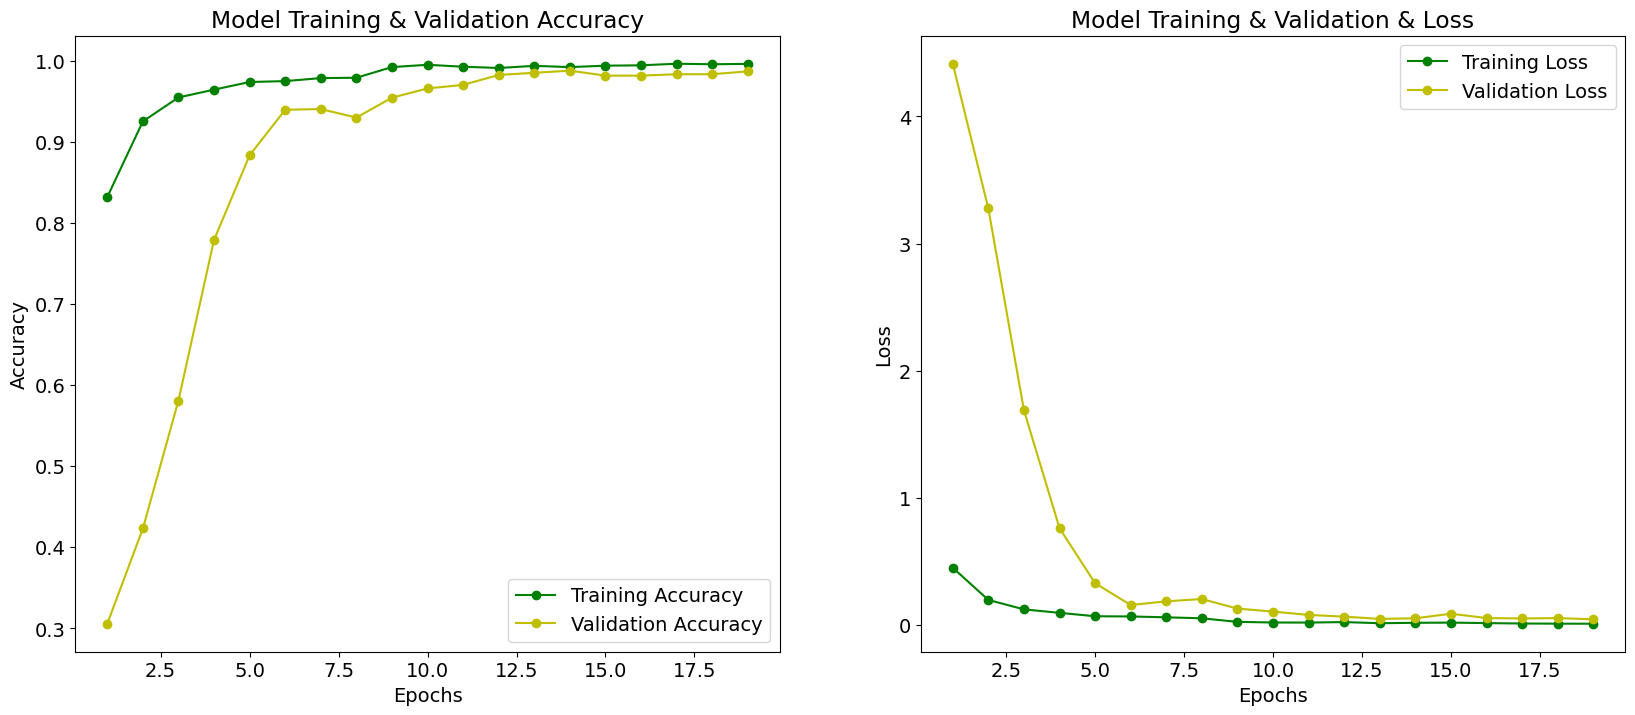

In [ ]:
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20, 8)

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

ax[0].plot(epochs , train_acc , 'g-o' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'y-o' , label = 'Validation Accuracy')
ax[0].set_title('Model Training & Validation Accuracy')
ax[0].legend(loc = 'lower right')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'y-o' , label = 'Validation Loss')
ax[1].set_title('Model Training & Validation & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()

In [ ]:
print('Train accuracy & loss:', model.evaluate(train_data))
print('\n')
print('Test accuracy & loss:', model.evaluate(test_data))

143/143 [==============================] - 82s 571ms/step - loss: 0.0081 - accuracy: 0.9972
Train accuracy & loss: [0.008131375536322594, 0.9971559643745422]


41/41 [==============================] - 24s 583ms/step - loss: 0.0488 - accuracy: 0.9886
Test accuracy & loss: [0.048835888504981995, 0.9885583519935608]


In [ ]:
#define labels for testing
y_test = test_data.classes

#make prediction
yhat_test = np.argmax(model.predict(test_data), axis=1)

41/41 [==============================] - 22s 510ms/step


In [ ]:
import itertools
from sklearn.metrics import confusion_matrix

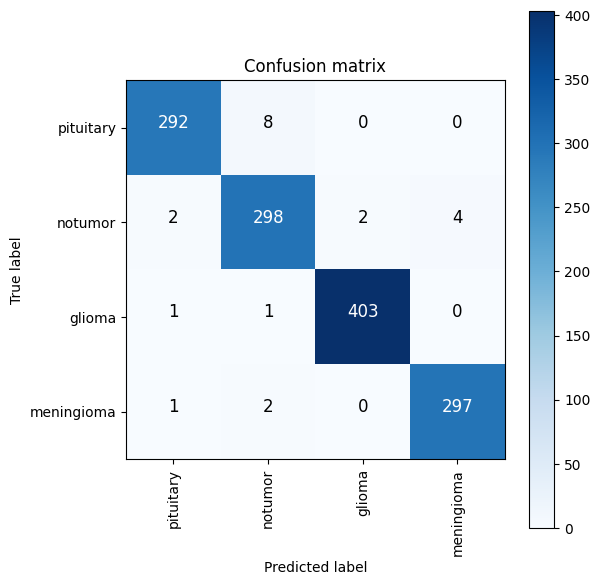

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Blues):

    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 fontsize = 12,
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

#get confusion matrix
cm = confusion_matrix(y_test, yhat_test)
#print(cm)

#plot
plot_confusion_matrix(cm, classes, normalize=False)

# **MobileNetV3Small**

In [ ]:
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras import regularizers

In [ ]:
base_model = MobileNetV3Small(input_shape = (240,240,3),weights='imagenet',include_top=False,pooling = 'max')

model_v3small = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(4, activation= 'softmax')
])

model_v3small.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model_v3small.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 MobilenetV3small (Function  (None, 576)               939120    
 al)                                                             
                                                                 
 batch_normalization_3 (Bat  (None, 576)               2304      
 chNormalization)                                                
                                                                 
 dense_3 (Dense)             (None, 256)               147712    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 1090164 (4.16 MB)
Trainable params: 1076

In [ ]:
mobileV3 = MobileNetV3Small(input_shape = (240,240,3),weights='imagenet',include_top=False,pooling = 'max')

model2 = mobileV3.output
model2 = GlobalAveragePooling2D()(model2)
model2 = Dense(1024,activation='relu')(model2)
model2 = Dropout(0.2)(model2)
model2 = Dense(1024,activation='relu')(model2)
model2 = Dropout(0.2)(model2)

model2 = Dense(4, activation='softmax')(model2)
model2 = Model(inputs=mobileV3.input,outputs=model2)

model2.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 240, 240, 3)]        0         []                            
                                                                                                  
 rescaling_5 (Rescaling)     (None, 240, 240, 3)          0         ['input_6[0][0]']             
                                                                                                  
 Conv (Conv2D)               (None, 120, 120, 16)         432       ['rescaling_5[0][0]']         
                                                                                                  
 Conv/BatchNorm (BatchNorma  (None, 120, 120, 16)         64        ['Conv[0][0]']                
 lization)                                                                                  

In [ ]:
#compile model
"""model2.compile(optimizer=Adam(learning_rate= 0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])"""

#define checkpoint
checkpoint = ModelCheckpoint('modelV3.h5',
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='auto',
                             verbose=1)

#early stopping
earlystop = EarlyStopping(monitor='val_accuracy',
                          patience=5,
                          mode='auto',
                          verbose=1)

#reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy',
                              factor = 0.3,
                              patience = 2,
                              min_delta = 0.001,
                              mode='auto',
                              verbose=1)

In [ ]:
historyV3 = model_v3small.fit(train_data,
                    epochs = 40,
                    validation_data=valid_data,
                    verbose=1,
                    callbacks=[checkpoint, earlystop, reduce_lr])

Epoch 1/40
143/143 [==============================] - ETA: 0s - loss: 5.7558 - accuracy: 0.8044
Epoch 1: val_accuracy improved from -inf to 0.75197, saving model to modelV3.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


143/143 [==============================] - 130s 914ms/step - loss: 5.7558 - accuracy: 0.8044 - val_loss: 4.9081 - val_accuracy: 0.7520 - lr: 0.0010
Epoch 2/40
143/143 [==============================] - ETA: 0s - loss: 3.7453 - accuracy: 0.9158
Epoch 2: val_accuracy improved from 0.75197 to 0.83173, saving model to modelV3.h5
143/143 [==============================] - 108s 760ms/step - loss: 3.7453 - accuracy: 0.9158 - val_loss: 3.3475 - val_accuracy: 0.8317 - lr: 0.0010
Epoch 3/40
143/143 [==============================] - ETA: 0s - loss: 2.5824 - accuracy: 0.9385
Epoch 3: val_accuracy did not improve from 0.83173
143/143 [==============================] - 125s 874ms/step - loss: 2.5824 - accuracy: 0.9385 - val_loss: 2.5725 - val_accuracy: 0.7555 - lr: 0.0010
Epoch 4/40
143/143 [==============================] - ETA: 0s - loss: 1.8436 - accuracy: 0.9521
Epoch 4: val_accuracy did not improve from 0.83173
143/143 [==============================] - 103s 722ms/step - loss: 1.8436 - accurac

In [ ]:
import os
import dill
from google.colab import drive

backup_dir = 'drive/MyDrive/Thesis'
backup_file = 'MobileNet.db'
backup_path = backup_dir + '/' + backup_file

def init_drive():
    # create directory if not exist
    drive.mount('drive')
    if not os.path.exists(backup_dir):
        !mkdir $backup_dir  # Use $backup_dir to reference the variable

def restart_kernel():
    os._exit(00)

def save_session():
    try:
        # Attempt to save the session
        if 'datagen' in locals():
            del datagen  # Remove the generator from the local namespace
        dill.dump_session(backup_path)
        #dill.dump_session(backup_path)
        print("Session saved successfully.")
    except Exception as e:
        print(f"Error saving session: {e}")

def load_session():
    try:
        # Attempt to load the session
        dill.load_session(backup_path)
        print("Session loaded successfully.")
    except Exception as e:
        print(f"Error loading session: {e}")

# Call the functions
#init_drive()
save_session()


Error saving session: cannot pickle 'generator' object
